<h1 style="text-align: center; color: #E30613;"><b><i>Entraînement avec LSTM sur les Données de Sentiments</i></b></h1>

<p style="font-size: 18px; color: #333;">
Ce notebook présente une approche complète pour l'entraînement d'un modèle LSTM (Long Short-Term Memory) sur des données de sentiments.
L'objectif est de prédire les sentiments exprimés dans des commentaires textuels en utilisant des techniques avancées de traitement du langage naturel (NLP).
</p>

### <span style="color: #28A745;">**Étapes principales du workflow :**</span>

1. **Chargement des données :** Importation et nettoyage des données textuelles.
2. **Encodage des étiquettes :** Transformation des sentiments en valeurs numériques.
3. **Division des données :** Séparation des données en ensembles d'entraînement, de validation et de test.
4. **Vectorisation :** Conversion des textes en vecteurs numériques à l'aide de `CountVectorizer`.
5. **Création d'un Dataset personnalisé :** Préparation des données pour le DataLoader de PyTorch.
6. **Définition du modèle LSTM :** Construction et configuration du modèle LSTM pour la classification.
7. **Entraînement :** Optimisation des paramètres du modèle à l'aide de la descente de gradient.
8. **Évaluation :** Analyse des performances du modèle avec des métriques et des visualisations.

### <span style="color: #28A745;">**Technologies utilisées :**</span>

- **PyTorch :** Framework pour la construction et l'entraînement du modèle LSTM.
- **Scikit-learn :** Prétraitement des données et évaluation des performances.
- **Matplotlib & Seaborn :** Visualisation des résultats et des métriques.
- **TQDM :** Suivi des progrès pendant l'entraînement.

<p style="font-size: 16px; color: #555;">
<b>Note :</b> Ce projet est conçu pour démontrer une approche pratique et reproductible pour l'analyse des sentiments à l'aide de réseaux de neurones récurrents.
</p>

# <span style="color: #E30613;">**LSTM**</span>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [138]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## <span style="color: #28A745;">**Utilisation de GPU**</span>

In [139]:
# ✅ GPU seulement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## <span style="color: #28A745;">**Chargement des Données**</span>

In [ ]:
# 📁 Chargement des données
df = pd.read_csv("/content/Results/Comments_clean.csv")
df = df.dropna(subset=["Comments"])

## <span style="color: #28A745;">**Encodage des étiquettes**</span>

In [141]:
# 🎯 Encodage des étiquettes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])

## <span style="color: #28A745;">**Division des données**</span>

In [142]:
# ✂️ Division des données
X_temp, X_test, y_temp, y_test = train_test_split(df["Comments"], df["Sentiments_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiments_encoded"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 * 0.8 = 0.1

## <span style="color: #28A745;">**Vectorisation avec CountVectorizer**</span>

In [143]:
# 🧠 Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

## <span style="color: #28A745;">**Dataset personnalisé**</span>

In [144]:
# 📦 Dataset personnalisé
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CommentDataset(X_train_vec, y_train)
val_dataset = CommentDataset(X_val_vec, y_val)
test_dataset = CommentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## <span style="color: #28A745;">**Entraînement avec LSTM**</span>

In [ ]:
# 🧱 Modèle LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

input_dim = X_train_vec.shape[1]
model = SentimentLSTM(input_dim=input_dim, hidden_dim=128, output_dim=3, n_layers=2, dropout=0.3)
model = model.to(device)

# 🔧 Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00009, weight_decay=2e-5, eps=0.00001)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 2  # Nombre d'époques sans amélioration avant l'arrêt anticipé
epochs_no_improve = 0

for epoch in range(100):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/content/Results/best_model_LSTM.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("⛔ Early stopping triggered")
            break

Epoch 1 [Training]: 100%|██████████| 80/80 [00:02<00:00, 38.36it/s, loss=1.09]



Epoch 1 - Train Loss: 1.0984, Val Loss: 1.0971, Train Acc: 0.3318, Val Acc: 0.3453


Epoch 2 [Training]: 100%|██████████| 80/80 [00:02<00:00, 39.02it/s, loss=1.09]



Epoch 2 - Train Loss: 1.0958, Val Loss: 1.0944, Train Acc: 0.4132, Val Acc: 0.5552


Epoch 3 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.15it/s, loss=1.06]



Epoch 3 - Train Loss: 1.0920, Val Loss: 1.0899, Train Acc: 0.4828, Val Acc: 0.4365


Epoch 4 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.08it/s, loss=1.15]



Epoch 4 - Train Loss: 1.0856, Val Loss: 1.0821, Train Acc: 0.4361, Val Acc: 0.4365


Epoch 5 [Training]: 100%|██████████| 80/80 [00:02<00:00, 38.87it/s, loss=0.954]



Epoch 5 - Train Loss: 1.0737, Val Loss: 1.0672, Train Acc: 0.4361, Val Acc: 0.4365


Epoch 6 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.48it/s, loss=0.771]



Epoch 6 - Train Loss: 1.0509, Val Loss: 1.0421, Train Acc: 0.4393, Val Acc: 0.4420


Epoch 7 [Training]: 100%|██████████| 80/80 [00:01<00:00, 49.00it/s, loss=0.778]



Epoch 7 - Train Loss: 1.0203, Val Loss: 1.0145, Train Acc: 0.4472, Val Acc: 0.4530


Epoch 8 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.65it/s, loss=1.17] 



Epoch 8 - Train Loss: 0.9889, Val Loss: 0.9899, Train Acc: 0.4761, Val Acc: 0.4641


Epoch 9 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.24it/s, loss=0.566]



Epoch 9 - Train Loss: 0.9618, Val Loss: 0.9676, Train Acc: 0.5235, Val Acc: 0.5166


Epoch 10 [Training]: 100%|██████████| 80/80 [00:01<00:00, 49.90it/s, loss=0.629]



Epoch 10 - Train Loss: 0.9346, Val Loss: 0.9463, Train Acc: 0.5860, Val Acc: 0.5470


Epoch 11 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.76it/s, loss=0.718]



Epoch 11 - Train Loss: 0.9099, Val Loss: 0.9274, Train Acc: 0.6327, Val Acc: 0.6022


Epoch 12 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.56it/s, loss=1.06] 



Epoch 12 - Train Loss: 0.8867, Val Loss: 0.9113, Train Acc: 0.6706, Val Acc: 0.6133


Epoch 13 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.13it/s, loss=0.923]



Epoch 13 - Train Loss: 0.8678, Val Loss: 0.8975, Train Acc: 0.7034, Val Acc: 0.6271


Epoch 14 [Training]: 100%|██████████| 80/80 [00:01<00:00, 52.72it/s, loss=0.552]



Epoch 14 - Train Loss: 0.8500, Val Loss: 0.8858, Train Acc: 0.7200, Val Acc: 0.6464


Epoch 15 [Training]: 100%|██████████| 80/80 [00:01<00:00, 44.22it/s, loss=1.03] 



Epoch 15 - Train Loss: 0.8362, Val Loss: 0.8758, Train Acc: 0.7422, Val Acc: 0.6575


Epoch 16 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.53it/s, loss=0.573]



Epoch 16 - Train Loss: 0.8219, Val Loss: 0.8663, Train Acc: 0.7624, Val Acc: 0.6823


Epoch 17 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.93it/s, loss=0.667]



Epoch 17 - Train Loss: 0.8077, Val Loss: 0.8569, Train Acc: 0.7932, Val Acc: 0.7017


Epoch 18 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.34it/s, loss=1.15] 



Epoch 18 - Train Loss: 0.7927, Val Loss: 0.8464, Train Acc: 0.8284, Val Acc: 0.7182


Epoch 19 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.66it/s, loss=0.552]



Epoch 19 - Train Loss: 0.7759, Val Loss: 0.8357, Train Acc: 0.8592, Val Acc: 0.7265


Epoch 20 [Training]: 100%|██████████| 80/80 [00:01<00:00, 49.25it/s, loss=0.862]



Epoch 20 - Train Loss: 0.7587, Val Loss: 0.8238, Train Acc: 0.8822, Val Acc: 0.7376


Epoch 21 [Training]: 100%|██████████| 80/80 [00:01<00:00, 41.07it/s, loss=0.591]



Epoch 21 - Train Loss: 0.7388, Val Loss: 0.8114, Train Acc: 0.8964, Val Acc: 0.7790


Epoch 22 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.73it/s, loss=0.781]



Epoch 22 - Train Loss: 0.7210, Val Loss: 0.8013, Train Acc: 0.9004, Val Acc: 0.7901


Epoch 23 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.80it/s, loss=0.552]



Epoch 23 - Train Loss: 0.7056, Val Loss: 0.7922, Train Acc: 0.9047, Val Acc: 0.7901


Epoch 24 [Training]: 100%|██████████| 80/80 [00:01<00:00, 43.35it/s, loss=0.613]



Epoch 24 - Train Loss: 0.6919, Val Loss: 0.7842, Train Acc: 0.9063, Val Acc: 0.7901


Epoch 25 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.78it/s, loss=0.773]



Epoch 25 - Train Loss: 0.6800, Val Loss: 0.7782, Train Acc: 0.9106, Val Acc: 0.7901


Epoch 26 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.24it/s, loss=0.567]



Epoch 26 - Train Loss: 0.6700, Val Loss: 0.7726, Train Acc: 0.9166, Val Acc: 0.7983


Epoch 27 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.96it/s, loss=0.553]



Epoch 27 - Train Loss: 0.6620, Val Loss: 0.7671, Train Acc: 0.9225, Val Acc: 0.8011


Epoch 28 [Training]: 100%|██████████| 80/80 [00:01<00:00, 46.27it/s, loss=0.799]



Epoch 28 - Train Loss: 0.6540, Val Loss: 0.7630, Train Acc: 0.9245, Val Acc: 0.8094


Epoch 29 [Training]: 100%|██████████| 80/80 [00:01<00:00, 42.83it/s, loss=1.55] 



Epoch 29 - Train Loss: 0.6489, Val Loss: 0.7593, Train Acc: 0.9284, Val Acc: 0.8122


Epoch 30 [Training]: 100%|██████████| 80/80 [00:01<00:00, 44.26it/s, loss=0.551]



Epoch 30 - Train Loss: 0.6443, Val Loss: 0.7561, Train Acc: 0.9316, Val Acc: 0.8177


Epoch 31 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.05it/s, loss=0.552]



Epoch 31 - Train Loss: 0.6376, Val Loss: 0.7533, Train Acc: 0.9355, Val Acc: 0.8122


Epoch 32 [Training]: 100%|██████████| 80/80 [00:02<00:00, 37.86it/s, loss=0.6]  



Epoch 32 - Train Loss: 0.6346, Val Loss: 0.7509, Train Acc: 0.9359, Val Acc: 0.8177


Epoch 33 [Training]: 100%|██████████| 80/80 [00:03<00:00, 24.39it/s, loss=0.554]



Epoch 33 - Train Loss: 0.6306, Val Loss: 0.7483, Train Acc: 0.9387, Val Acc: 0.8177


Epoch 34 [Training]: 100%|██████████| 80/80 [00:01<00:00, 41.72it/s, loss=0.556]



Epoch 34 - Train Loss: 0.6287, Val Loss: 0.7466, Train Acc: 0.9371, Val Acc: 0.8177


Epoch 35 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.50it/s, loss=0.588]



Epoch 35 - Train Loss: 0.6252, Val Loss: 0.7442, Train Acc: 0.9442, Val Acc: 0.8177


Epoch 36 [Training]: 100%|██████████| 80/80 [00:01<00:00, 46.93it/s, loss=0.552]



Epoch 36 - Train Loss: 0.6214, Val Loss: 0.7423, Train Acc: 0.9439, Val Acc: 0.8177


Epoch 37 [Training]: 100%|██████████| 80/80 [00:01<00:00, 42.90it/s, loss=0.563]



Epoch 37 - Train Loss: 0.6195, Val Loss: 0.7408, Train Acc: 0.9478, Val Acc: 0.8177


Epoch 38 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.25it/s, loss=0.551]



Epoch 38 - Train Loss: 0.6174, Val Loss: 0.7393, Train Acc: 0.9474, Val Acc: 0.8177


Epoch 39 [Training]: 100%|██████████| 80/80 [00:01<00:00, 51.94it/s, loss=0.552]



Epoch 39 - Train Loss: 0.6161, Val Loss: 0.7375, Train Acc: 0.9478, Val Acc: 0.8177


Epoch 40 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.84it/s, loss=0.552]



Epoch 40 - Train Loss: 0.6132, Val Loss: 0.7367, Train Acc: 0.9498, Val Acc: 0.8177


Epoch 41 [Training]: 100%|██████████| 80/80 [00:01<00:00, 48.09it/s, loss=0.553]



Epoch 41 - Train Loss: 0.6123, Val Loss: 0.7356, Train Acc: 0.9490, Val Acc: 0.8177


Epoch 42 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.90it/s, loss=0.587]



Epoch 42 - Train Loss: 0.6098, Val Loss: 0.7345, Train Acc: 0.9545, Val Acc: 0.8232


Epoch 43 [Training]: 100%|██████████| 80/80 [00:01<00:00, 43.87it/s, loss=0.552]



Epoch 43 - Train Loss: 0.6077, Val Loss: 0.7332, Train Acc: 0.9537, Val Acc: 0.8177


Epoch 44 [Training]: 100%|██████████| 80/80 [00:01<00:00, 41.10it/s, loss=0.556]



Epoch 44 - Train Loss: 0.6075, Val Loss: 0.7325, Train Acc: 0.9533, Val Acc: 0.8232


Epoch 45 [Training]: 100%|██████████| 80/80 [00:01<00:00, 47.64it/s, loss=0.551]



Epoch 45 - Train Loss: 0.6053, Val Loss: 0.7320, Train Acc: 0.9553, Val Acc: 0.8204


Epoch 46 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.02it/s, loss=0.565]



Epoch 46 - Train Loss: 0.6050, Val Loss: 0.7314, Train Acc: 0.9541, Val Acc: 0.8177


Epoch 47 [Training]: 100%|██████████| 80/80 [00:01<00:00, 41.62it/s, loss=0.551]



Epoch 47 - Train Loss: 0.6038, Val Loss: 0.7311, Train Acc: 0.9569, Val Acc: 0.8204


Epoch 48 [Training]: 100%|██████████| 80/80 [00:01<00:00, 43.27it/s, loss=0.557]



Epoch 48 - Train Loss: 0.6026, Val Loss: 0.7307, Train Acc: 0.9561, Val Acc: 0.8177


Epoch 49 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.59it/s, loss=0.566]



Epoch 49 - Train Loss: 0.6014, Val Loss: 0.7308, Train Acc: 0.9573, Val Acc: 0.8177


Epoch 50 [Training]: 100%|██████████| 80/80 [00:01<00:00, 45.54it/s, loss=1.47] 



Epoch 50 - Train Loss: 0.6017, Val Loss: 0.7308, Train Acc: 0.9553, Val Acc: 0.8177
⛔ Early stopping triggered


## <span style="color: #28A745;">**Graphique des pertes**</span>

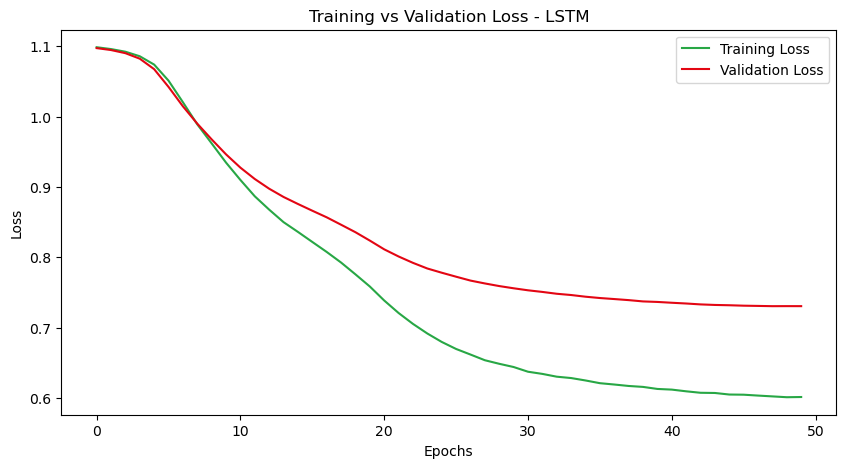

In [146]:
# 📉 Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color='#28A745')
plt.plot(val_losses, label="Validation Loss", color='#E30613')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - LSTM")
plt.legend()
plt.show()

## <span style="color: #28A745;">**Évaluation finale**</span>

In [ ]:
# ✅ Évaluation finale
model.load_state_dict(torch.load("/content/Results/best_model_LSTM.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Rapport de classification
print("\n🔍 Rapport de classification pour LSTM:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

C:\Users\kikoo\AppData\Local\Temp\ipykernel_27876\4166534504.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Results/best_model_LSTM.pt


🔍 Rapport de classification pour LSTM:
              precision    recall  f1-score   support

     Negatif       0.91      0.84      0.87       172
      Neutre       0.80      0.82      0.81       236
     Positif       0.91      0.93      0.92       315

    accuracy                           0.87       723
   macro avg       0.87      0.86      0.87       723
weighted avg       0.87      0.87      0.87       723



## <span style="color: #28A745;">**Matrice de confusion**</span>

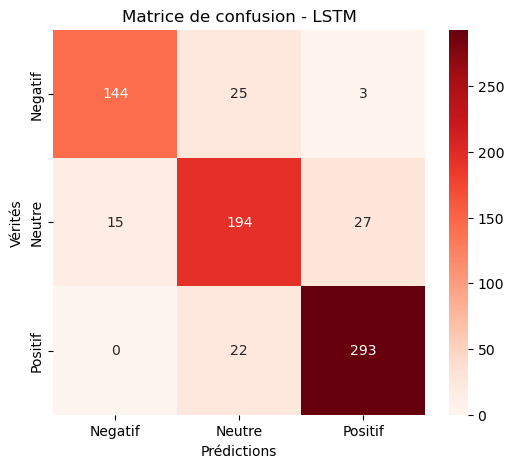

In [150]:
# 📌 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - LSTM")
plt.show()

<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>